In [1]:
from tools.log_controller import LogController
from pathlib import Path

log_controller = LogController(config_path=Path('config', 'logging_config.json'))
log_controller.start()

In [2]:
from core.data_repository import DataRepository
from pathlib import Path


data_repository = DataRepository(repo_path=Path('repo'))
AMZN_periodic_data = data_repository.get_dataframes()['AMZN']

 2025-10-26 12:27:59 - data_repository - INFO - Loaded: AAPL
 2025-10-26 12:27:59 - data_repository - INFO - Loaded: AMZN_enhanced
 2025-10-26 12:27:59 - data_repository - INFO - Loaded: AMZN_enhanced
 2025-10-26 12:27:59 - data_repository - INFO - Loaded: IBM
 2025-10-26 12:27:59 - data_repository - INFO - Loaded: AMZN
 2025-10-26 12:27:59 - data_repository - INFO - Loaded periodic stock market data for: {'AMZN', 'AMZN_enhanced', 'AAPL', 'IBM'}
 2025-10-26 12:27:59 - data_repository - INFO - Loaded: IBM
 2025-10-26 12:27:59 - data_repository - INFO - Loaded: AMZN
 2025-10-26 12:27:59 - data_repository - INFO - Loaded periodic stock market data for: {'AMZN', 'AMZN_enhanced', 'AAPL', 'IBM'}


In [3]:
# Filter
from core.data_preparator import DataPreparator
import numpy as np

AMZN_periodic_data_filtered = DataPreparator.apply_kalman_filter(
    AMZN_periodic_data,
    F=np.array([[1, 1], [0, 1]]),
    H=np.array([[1, 0]]),
    Q=np.array([[1, 0], [0, 3]])*0.01,
    R=np.array([[10]]),
    P=np.array([[1, 0], [0, 1]])*1000,
)

 2025-10-26 12:28:00 - data_preparator - INFO - Applying Kalman filter to target column: Close


In [ ]:
from core.data_preparator import DataPreparator
AMZN_supervised_data = DataPreparator.reformat_periodic_to_supervised_data(
    dataframe=AMZN_periodic_data_filtered,
    target_column='Close',
    t=3
)



 2025-10-26 12:28:00 - data_preparator - INFO - Preparing data for target column: Close, with t=3


In [5]:
# Attach original (unfiltered) Close for evaluation by aligned index
AMZN_supervised_data['Close_original'] = AMZN_periodic_data.loc[AMZN_supervised_data.index, 'Close'].astype(float).values
AMZN_supervised_data.head()

,Close,Close_0,Close_1,Close_2,Close_original
Date,,,,,
2022-01-06,162.710617,164.438725,167.576142,170.404495,163.253998
2022-01-07,161.637244,162.710617,164.438725,167.576142,162.554001
2022-01-10,160.614620,161.637244,162.710617,164.438725,161.485992
2022-01-11,161.921718,160.614620,161.637244,162.710617,165.362000
2022-01-12,162.735658,161.921718,160.614620,161.637244,165.207001


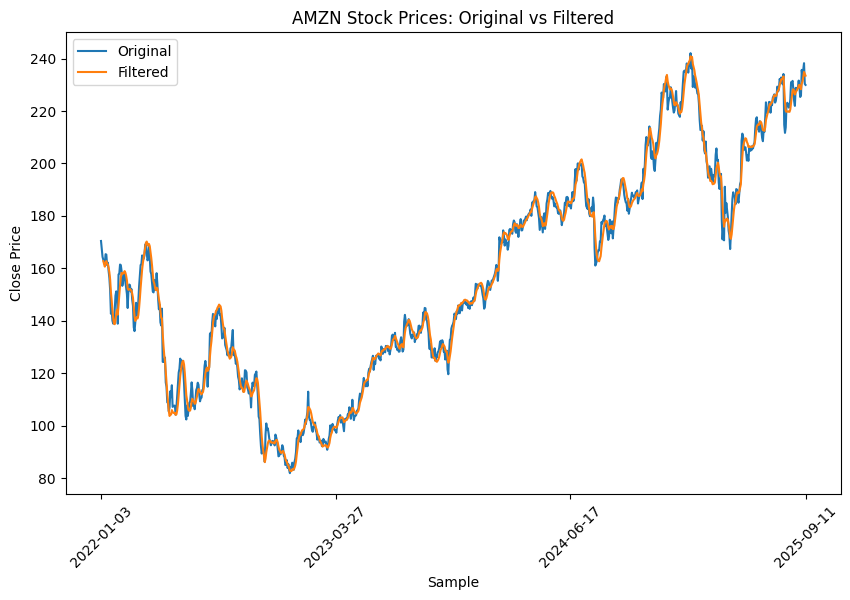

In [6]:
from tools.data_visualizer import plot_original_vs_filtered

plot_original_vs_filtered(AMZN_periodic_data, AMZN_supervised_data, column='Close', title='AMZN Stock Prices: Original vs Filtered')

In [7]:
from core.dataset import StockDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

AMZN_train_dataset, AMZN_test_dataset = train_test_split(AMZN_supervised_data, test_size=.1, shuffle=False, random_state=42)
AMZN_train_dataset, AMZN_validation_dataset = train_test_split(AMZN_train_dataset, test_size=.2, shuffle=False, random_state=42)

In [8]:
AMZN_train_original = AMZN_train_dataset['Close_original']
AMZN_validation_original = AMZN_validation_dataset['Close_original']
AMZN_test_original = AMZN_test_dataset['Close_original']

AMZN_supervised_data.drop(columns=['Close_original'], inplace=True)
AMZN_train_dataset.drop(columns=['Close_original'], inplace=True)
AMZN_validation_dataset.drop(columns=['Close_original'], inplace=True)
AMZN_test_dataset.drop(columns=['Close_original'], inplace=True)

In [9]:
from core.data_preparator import DataPreparator

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

AMZN_train_dataset, AMZN_validation_dataset, AMZN_test_dataset = DataPreparator.scale_datasets(
    train_dataset=AMZN_train_dataset,
    validation_dataset=AMZN_validation_dataset,
    test_dataset=AMZN_test_dataset,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
    target_column='Close'
)

 2025-10-26 12:28:06 - data_preparator - INFO - Scaling datasets for target column: Close


In [10]:
AMZN_train_dataset = StockDataset(AMZN_train_dataset)
AMZN_validation_dataset = StockDataset(AMZN_validation_dataset)
AMZN_test_dataset = StockDataset(AMZN_test_dataset)

 2025-10-26 12:28:06 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close
 2025-10-26 12:28:06 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close
 2025-10-26 12:28:06 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close
 2025-10-26 12:28:06 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close
 2025-10-26 12:28:06 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close


In [11]:
# from models.lstm_model import LSTMStockModel

# best_params, best_value = LSTMStockModel.optimize_hyperparameters(
#     train_dataset=AMZN_train_dataset,
#     validation_dataset=AMZN_validation_dataset,
#     feature_number=timesteps_lookback,
#     ticker='AMZN',
#     input_dim=1,
#     output_dim=1,
#     n_trials=30
# )
# print(f'Best hyperparameters: {best_params}, Best MSE Loss: {best_value}')

In [12]:
from models.lstm_model import LSTMStockModel

AMZN_base_model = LSTMStockModel(
    id='base_amzn_model',
    ticker='AMZN',
    input_dim=1,
    hidden_dim=27,
    layer_dim=1,
    output_dim=1
)

 2025-10-26 12:28:07 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=27,
layer_dimension=1,
output_dimension=1)


/home/emdablju/Documents/projects/kalman_stock_prediction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
from torch.optim import Adam
from torch.nn import MSELoss

optimizer = Adam(AMZN_base_model.parameters(), lr=0.001)
loss_function = MSELoss()

In [ ]:
from torch.utils.data import DataLoader


AMZN_train_data_loader = DataLoader(AMZN_train_dataset, batch_size=16, shuffle=False)
AMZN_validation_data_loader = DataLoader(AMZN_validation_dataset, batch_size=10, shuffle=False)
epochs = 20
feature_number = AMZN_train_dataset.X.shape[1]

train_mse_list, val_mse_list, train_r2_list, val_r2_list, val_actuals, val_predictions, val_errors = AMZN_base_model.perform_training(
    train_loader=AMZN_train_data_loader,
    validation_loader=AMZN_validation_data_loader,
    optimizer=optimizer,
    loss_function=loss_function,
    epochs=epochs,
    feature_number=feature_number
)

 2025-10-26 12:28:08 - model - INFO - Epoch [1/20]
 2025-10-26 12:28:08 - model - INFO - Train MSE: 0.155467, R2: -1.3760
 2025-10-26 12:28:08 - model - INFO - Validation MSE: 0.476874, R2: -16.0003
 2025-10-26 12:28:08 - model - INFO - Train MSE: 0.155467, R2: -1.3760
 2025-10-26 12:28:08 - model - INFO - Validation MSE: 0.476874, R2: -16.0003
 2025-10-26 12:28:08 - model - INFO - Epoch [2/20]
 2025-10-26 12:28:08 - model - INFO - Train MSE: 0.052420, R2: 0.1989
 2025-10-26 12:28:08 - model - INFO - Validation MSE: 0.186291, R2: -5.6412
 2025-10-26 12:28:08 - model - INFO - Epoch [2/20]
 2025-10-26 12:28:08 - model - INFO - Train MSE: 0.052420, R2: 0.1989
 2025-10-26 12:28:08 - model - INFO - Validation MSE: 0.186291, R2: -5.6412
 2025-10-26 12:28:08 - model - INFO - Epoch [3/20]
 2025-10-26 12:28:08 - model - INFO - Train MSE: 0.053982, R2: 0.1750
 2025-10-26 12:28:08 - model - INFO - Epoch [3/20]
 2025-10-26 12:28:08 - model - INFO - Train MSE: 0.053982, R2: 0.1750
 2025-10-26 12:28

In [ ]:
AMZN_test_data_loader = DataLoader(AMZN_test_dataset, batch_size=10, shuffle=False)
feature_number = AMZN_test_dataset.X.shape[1]

actuals, predictions, errors = AMZN_base_model.evaluate(
    test_loader=AMZN_test_data_loader,
    loss_function=loss_function,
    scaler_y=scaler_y,
    feature_number=feature_number
)

 2025-10-26 12:28:10 - model - INFO - Test RMSE: 0.0268
 2025-10-26 12:28:10 - model - INFO - Test Loss (RMSE) on original scale: 3.0179
 2025-10-26 12:28:10 - model - INFO - Test Loss (RMSE) on original scale: 3.0179


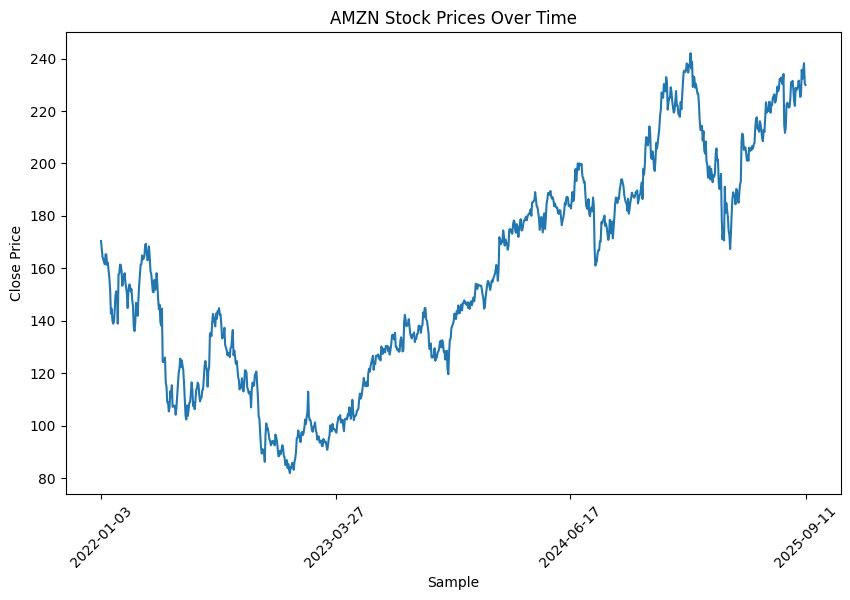

In [16]:
from tools.data_visualizer import plot_stock_prices
plot_stock_prices(AMZN_periodic_data, column='Close', title='AMZN Stock Prices Over Time')

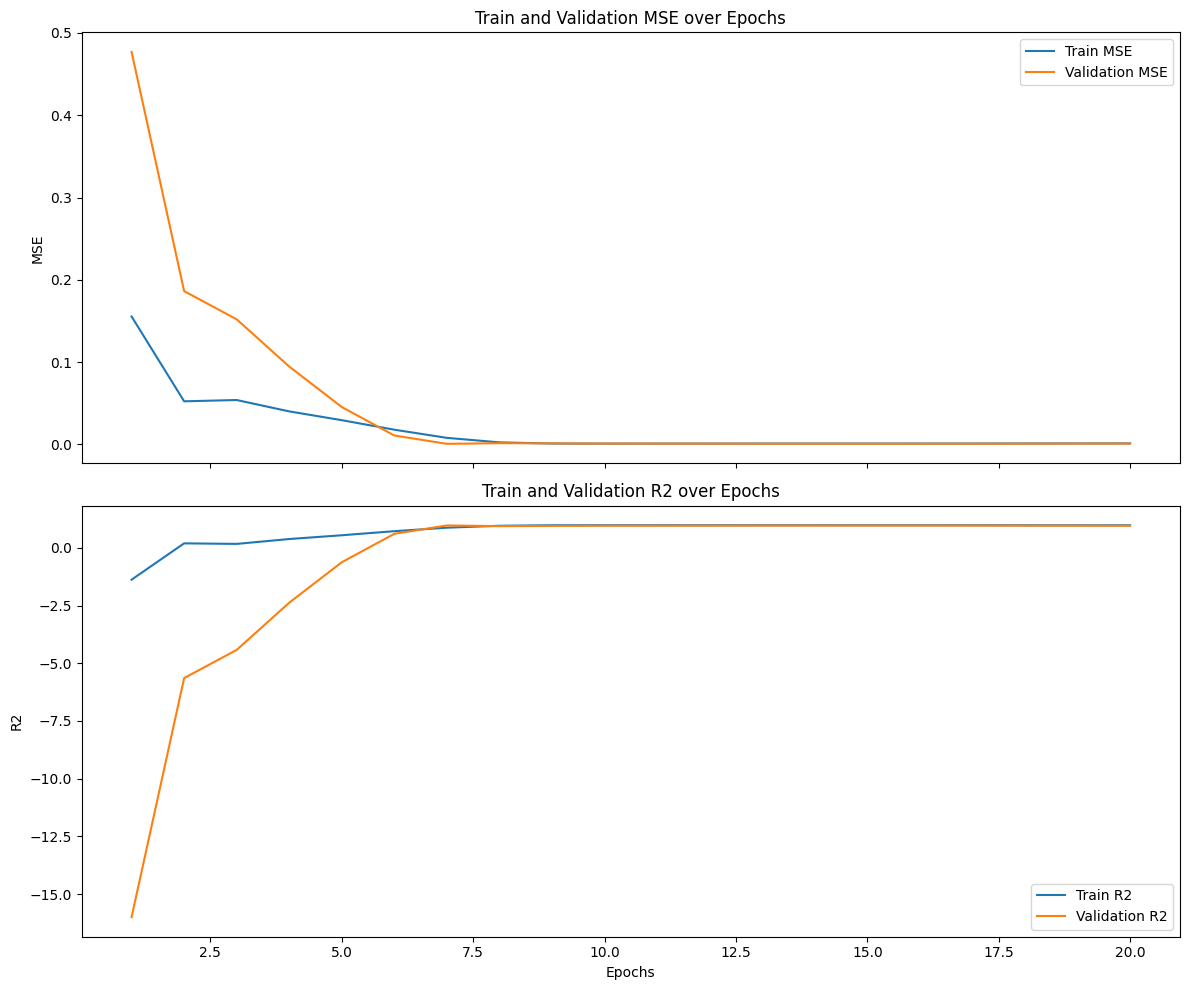

In [17]:
from tools.data_visualizer import plot_performance_metrics
plot_performance_metrics(train_mse_list, val_mse_list, train_r2_list, val_r2_list, epochs)

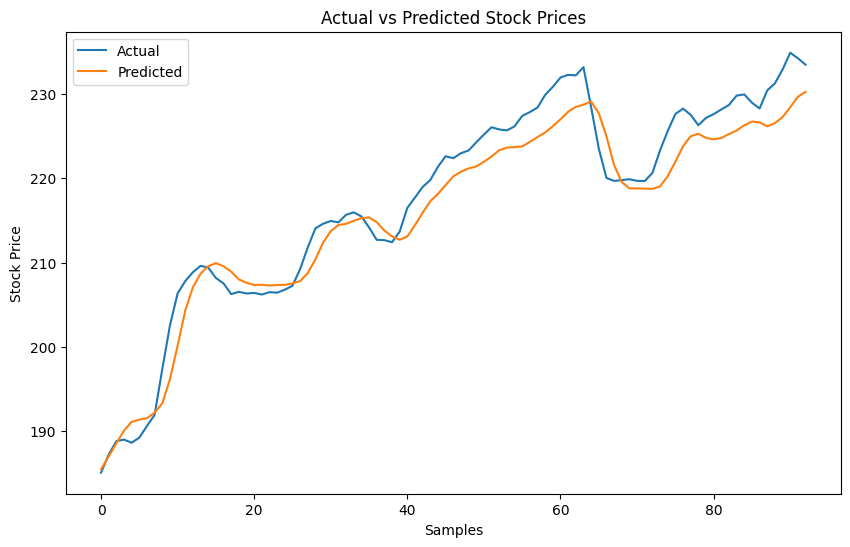

In [18]:
from tools.data_visualizer import plot_predictions

plot_predictions(actuals, predictions)

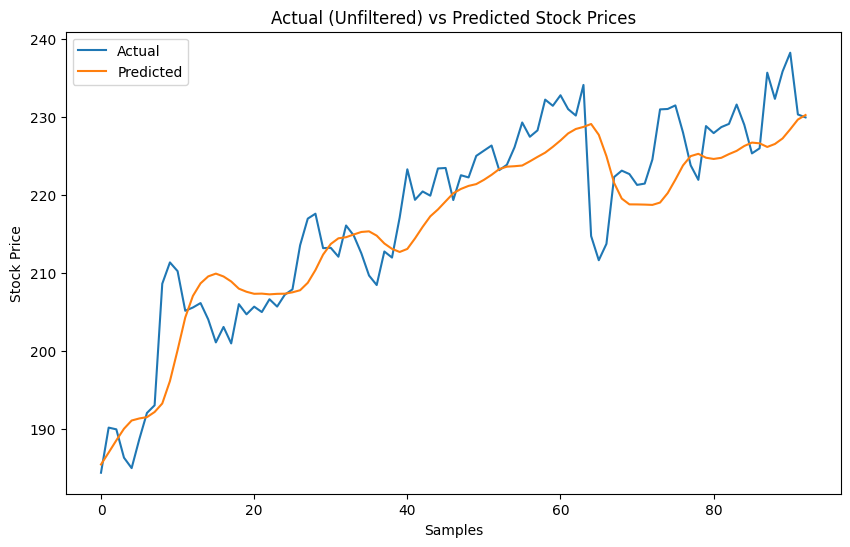

In [ ]:
actuals_original = AMZN_test_original.values
plot_predictions(actuals_original, predictions, title='Actual (Unfiltered) vs Predicted Stock Prices')

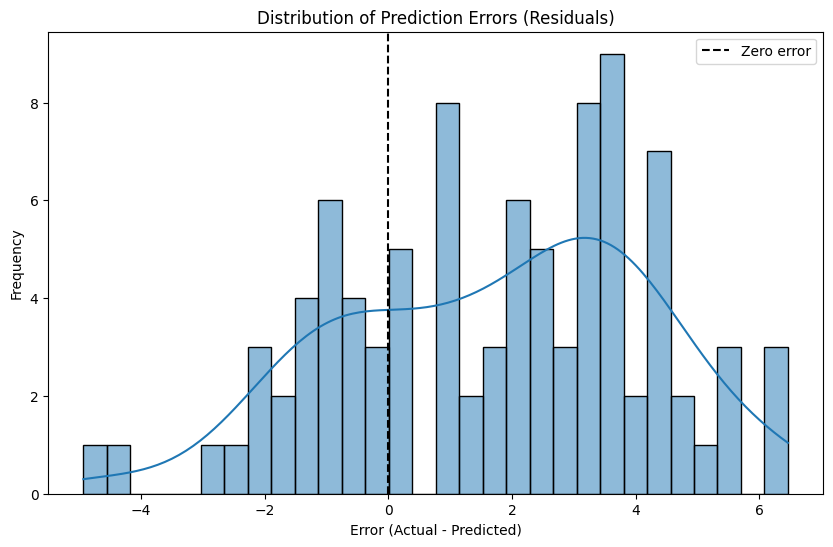

In [ ]:
from tools.data_visualizer import plot_errors
plot_errors(errors)

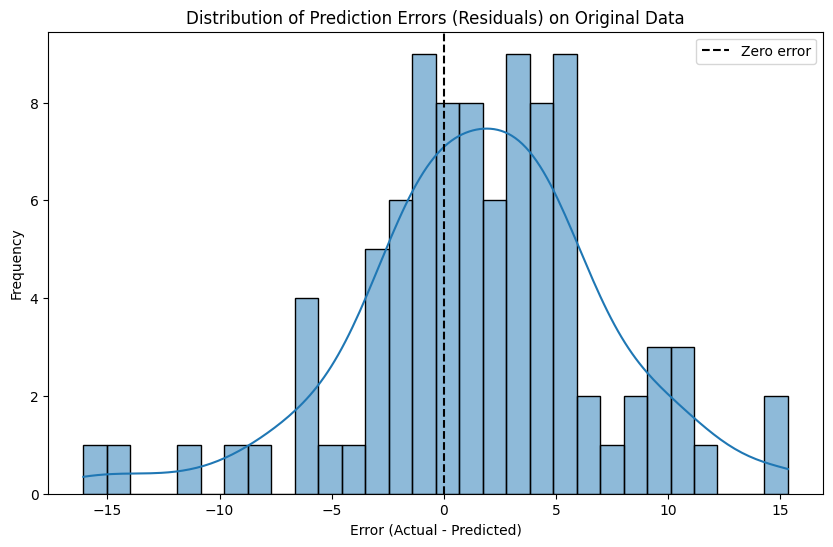

In [ ]:
from tools.data_visualizer import plot_errors
errors_original = actuals_original - predictions
plot_errors(errors_original, title='Distribution of Prediction Errors (Residuals) on Original Data')